In [1]:
import numpy as np

class SingleProductEnvironment:
    def __init__(self, prices, valuation_distribution, horizon, budget):
        self.prices = prices                    # List of possible prices
        self.valuation_distribution = valuation_distribution  # Function: () -> valuation
        self.T = horizon                        # Total time horizon
        self.B = budget                         # Inventory constraint
        self.t = 0                              # Current time step
        self.inventory_used = 0                 # Units sold

    def buyer_valuation(self):
        return self.valuation_distribution()

    def step(self, price):
        """
        Executes one round of interaction with the buyer.
        Returns reward and a flag indicating if a purchase happened.
        """
        if self.inventory_used >= self.B:
            return 0, False  # Budget exhausted

        valuation = self.buyer_valuation()
        if valuation >= price:
            self.inventory_used += 1
            return price, True
        else:
            return 0, False

    def reset(self):
        self.t = 0
        self.inventory_used = 0


In [2]:
class Agent:
    def __init__(self, prices):
        self.prices = prices

    def select_price(self, t):
        raise NotImplementedError

    def update(self, price, reward):
        raise NotImplementedError


## UCB1 ignoring the inventory constraint

In [3]:
import numpy as np

class UCB1Agent(Agent):
    def __init__(self, prices):
        super().__init__(prices)
        self.n_prices = len(prices)
        self.counts = np.zeros(self.n_prices)          # n_i
        self.rewards = np.zeros(self.n_prices)         # cumulative rewards for each price
        self.total_steps = 0

    def select_price(self, t):
        self.total_steps += 1
        if t <= self.n_prices:
            # Play each price once to initialize
            return self.prices[t - 1]
        else:
            avg_rewards = self.rewards / np.maximum(1, self.counts)
            confidence_bounds = np.sqrt((2 * np.log(t)) / np.maximum(1, self.counts))
            ucb_values = avg_rewards + confidence_bounds
            best_index = np.argmax(ucb_values)
            return self.prices[best_index]

    def update(self, price, reward):
        index = self.prices.tolist().index(price)
        self.counts[index] += 1
        self.rewards[index] += reward


## UCB1 with the inventory constraint

In [4]:
class UCBInventoryConstraintAgent(Agent):
    def __init__(self, prices, budget):
        super().__init__(prices)
        self.n_prices = len(prices)
        self.counts = np.zeros(self.n_prices)    # n_i
        self.rewards = np.zeros(self.n_prices)   # cumulative rewards
        self.total_steps = 0
        self.budget = budget                     # B
        self.units_sold = 0                      # b_t

    def select_price(self, t):
        self.total_steps += 1
        if t <= self.n_prices:
            # Ensure initial exploration: pull each arm once
            return self.prices[t - 1]
        else:
            avg_rewards = self.rewards / np.maximum(1, self.counts)
            exploration_weight = (self.budget - self.units_sold) / self.budget
            confidence_bonus = exploration_weight * np.sqrt((2 * np.log(t)) / np.maximum(1, self.counts))
            ucb_values = avg_rewards + confidence_bonus
            best_index = np.argmax(ucb_values)
            return self.prices[best_index]

    def update(self, price, reward):
        index = self.prices.tolist().index(price)
        self.counts[index] += 1
        self.rewards[index] += reward
        if reward > 0:
            self.units_sold += 1

In [5]:
def simulate(env, agent):
    rewards = []
    price_choices = []

    for t in range(1, env.T + 1):
        if env.inventory_used >= env.B:
            break

        price = agent.select_price(t)
        reward, _ = env.step(price)

        agent.update(price, reward)

        rewards.append(reward)
        price_choices.append(price)

    return rewards, price_choices


In [6]:
# --- Parameters and environment setup ---
prices = np.round(np.linspace(0.1, 1.0, 10), 2)
valuation_distribution = lambda: np.random.beta(2, 5)
budget = 1000
horizon = 10000

env = SingleProductEnvironment(prices, valuation_distribution, horizon=horizon, budget=budget)
agent1 = UCB1Agent(prices)
agent2 = UCBInventoryConstraintAgent(prices, budget=budget)


# --- Run simulation for UCB1 ---
env1 = SingleProductEnvironment(prices, valuation_distribution, horizon=horizon, budget=budget)
agent1 = UCB1Agent(prices)
rewards1, price_choices1 = simulate(env1, agent1)

# --- Run simulation for UCB1 with inventory ---
env2 = SingleProductEnvironment(prices, valuation_distribution, horizon=horizon, budget=budget)
agent2 = UCBInventoryConstraintAgent(prices, budget=budget)
rewards2, price_choices2 = simulate(env2, agent2)

print("Total Revenue of the UCB1 agent:", sum(rewards1))
print("Total Revenue of the UCB1 agent with inventory constraint:", sum(rewards2))

Total Revenue of the UCB1 agent: 218.39999999999864
Total Revenue of the UCB1 agent with inventory constraint: 208.49999999999554


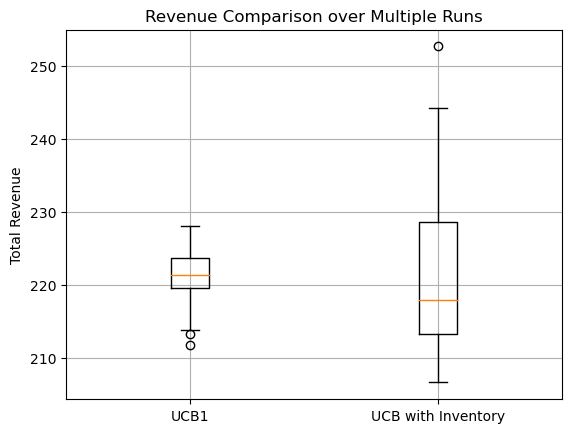

In [7]:
results_ucb1 = []
results_inv = []

for _ in range(20):
    env1 = SingleProductEnvironment(prices, valuation_distribution, horizon=horizon, budget=budget)
    agent1 = UCB1Agent(prices)
    rewards1, _ = simulate(env1, agent1)
    results_ucb1.append(sum(rewards1))

    env2 = SingleProductEnvironment(prices, valuation_distribution, horizon=horizon, budget=budget)
    agent2 = UCBInventoryConstraintAgent(prices, budget=budget)
    rewards2, _ = simulate(env2, agent2)
    results_inv.append(sum(rewards2))

# Plot comparison
import matplotlib.pyplot as plt

plt.boxplot([results_ucb1, results_inv], labels=["UCB1", "UCB with Inventory"])
plt.title("Revenue Comparison over Multiple Runs")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()

While vanilla UCB1 can occasionally outperform its inventory-aware counterpart when the inventory constraint is loose or the environment is forgiving, the inventory-aware variant provides more safety and long-term adaptability in constrained settings. Its occasional high-reward outliers suggest that managing exploration based on remaining inventory can sometimes uncover better pricing strategies without over-selling.

In [8]:
def estimate_expected_rewards(prices, valuation_distribution, n_samples=10000):
    valuations = np.array([valuation_distribution() for _ in range(n_samples)])
    expected_rewards = [p * np.mean(valuations >= p) for p in prices]
    return np.array(expected_rewards), valuations

def compute_regret_curve(price_choices, prices, expected_rewards):
    best_reward = np.max(expected_rewards)
    chosen_indices = [prices.tolist().index(p) for p in price_choices]
    chosen_rewards = expected_rewards[chosen_indices]
    instantaneous_regret = best_reward - chosen_rewards
    cumulative_regret = np.cumsum(instantaneous_regret)
    return cumulative_regret

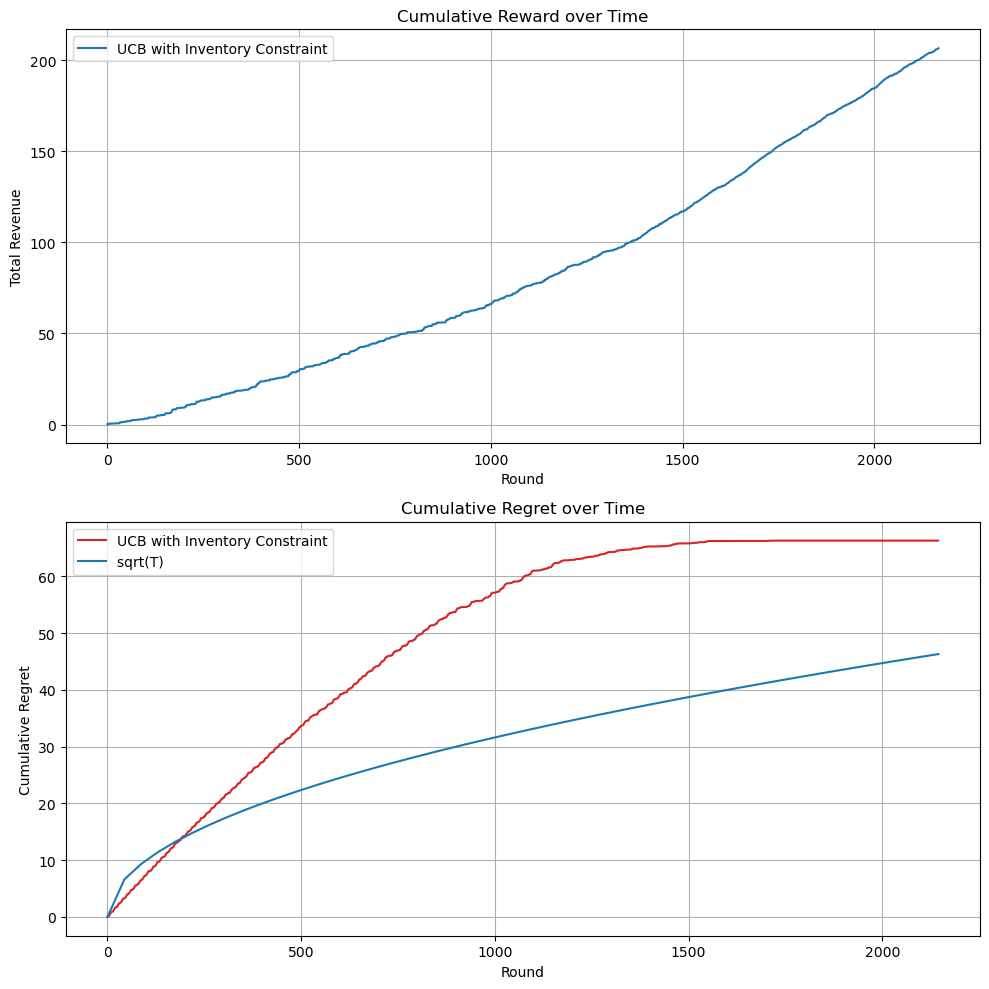

In [10]:
# --- Estimate true expected rewards for regret ---
expected_rewards, _ = estimate_expected_rewards(prices, valuation_distribution)
cumulative_regret = compute_regret_curve(price_choices2, prices, expected_rewards)
cumulative_reward = np.cumsum(rewards2)

T = np.linspace(0, len(cumulative_regret))

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot cumulative reward
axs[0].plot(cumulative_reward, label="UCB with Inventory Constraint", color='tab:blue')
axs[0].set_title("Cumulative Reward over Time")
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Total Revenue")
axs[0].legend()
axs[0].grid(True)

# Plot cumulative regret
axs[1].plot(cumulative_regret, label="UCB with Inventory Constraint", color='tab:red')
axs[1].plot(T, np.sqrt(T), label="sqrt(T) ")
axs[1].set_title("Cumulative Regret over Time")
axs[1].set_xlabel("Round")
axs[1].set_ylabel("Cumulative Regret")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Experiments with both agents

In [11]:
def run_experiment(valuation_distribution, prices, horizon, budget, agent_class, label):
    env = SingleProductEnvironment(prices, valuation_distribution, horizon, budget)
    agent = agent_class(prices) if agent_class == UCB1Agent else agent_class(prices, budget)
    rewards, price_choices = simulate(env, agent)

    expected_rewards, _ = estimate_expected_rewards(prices, valuation_distribution)
    cumulative_regret = compute_regret_curve(price_choices, prices, expected_rewards)
    cumulative_reward = np.cumsum(rewards)
    
    return cumulative_reward, cumulative_regret, label

In [12]:
# --- Common Setup ---
prices = np.round(np.linspace(0.1, 1.0, 20), 2)
horizon = 1000
budget = 300

distributions = {
    "Beta(2,5)": lambda: np.random.beta(2, 5),
    "Beta(5,2)": lambda: np.random.beta(5, 2),
    "Uniform(0,1)": lambda: np.random.uniform(0, 1)
}

agents = {
    "UCB1 (no constraint)": UCB1Agent,
    "UCB with Inventory": UCBInventoryConstraintAgent
}

# Store results
results = {}

for dist_name, dist_func in distributions.items():
    results[dist_name] = {}
    for agent_name, agent_class in agents.items():
        reward, regret, label = run_experiment(dist_func, prices, horizon, budget, agent_class, agent_name)
        results[dist_name][agent_name] = {"reward": reward, "regret": regret}


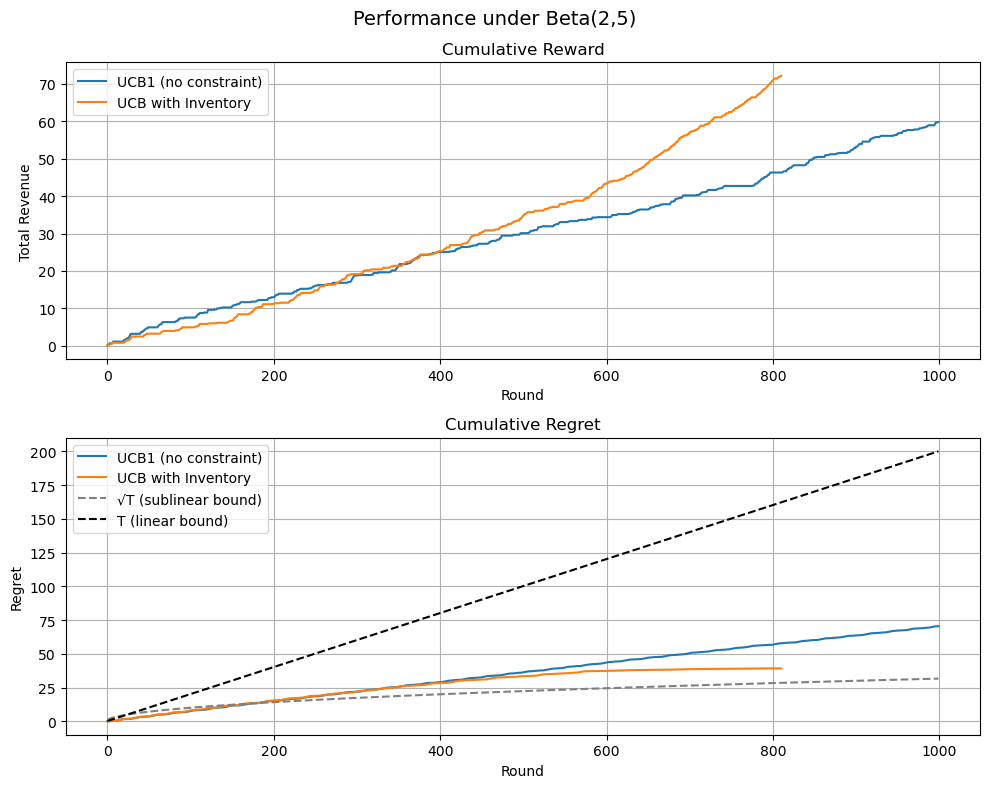

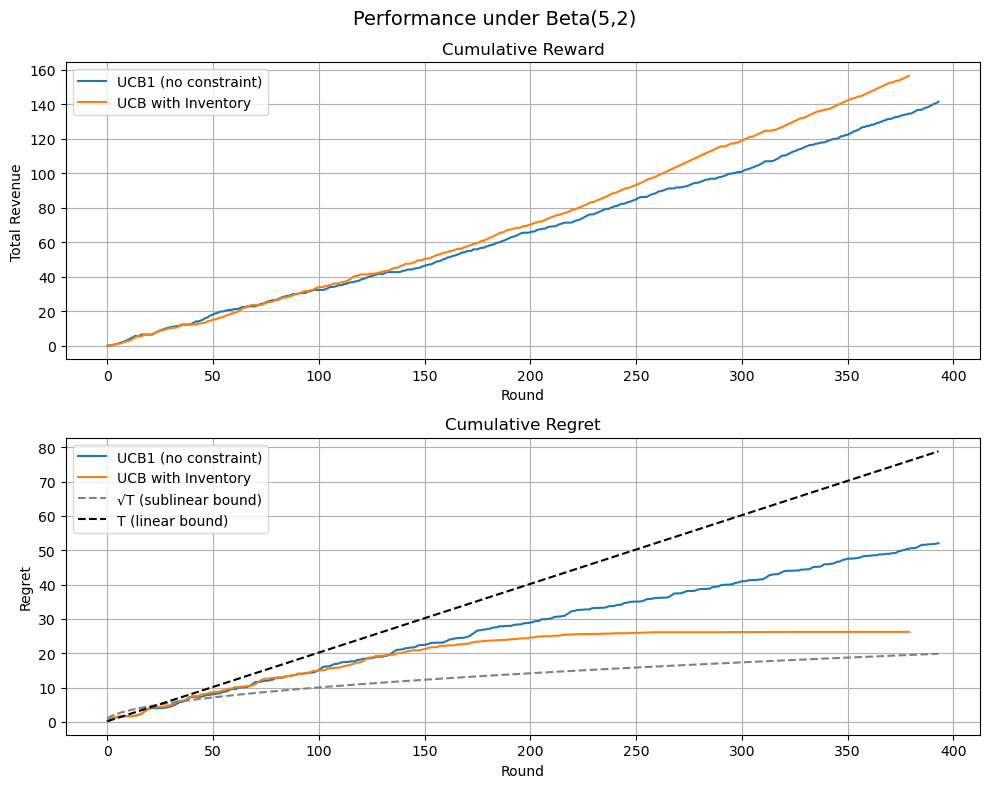

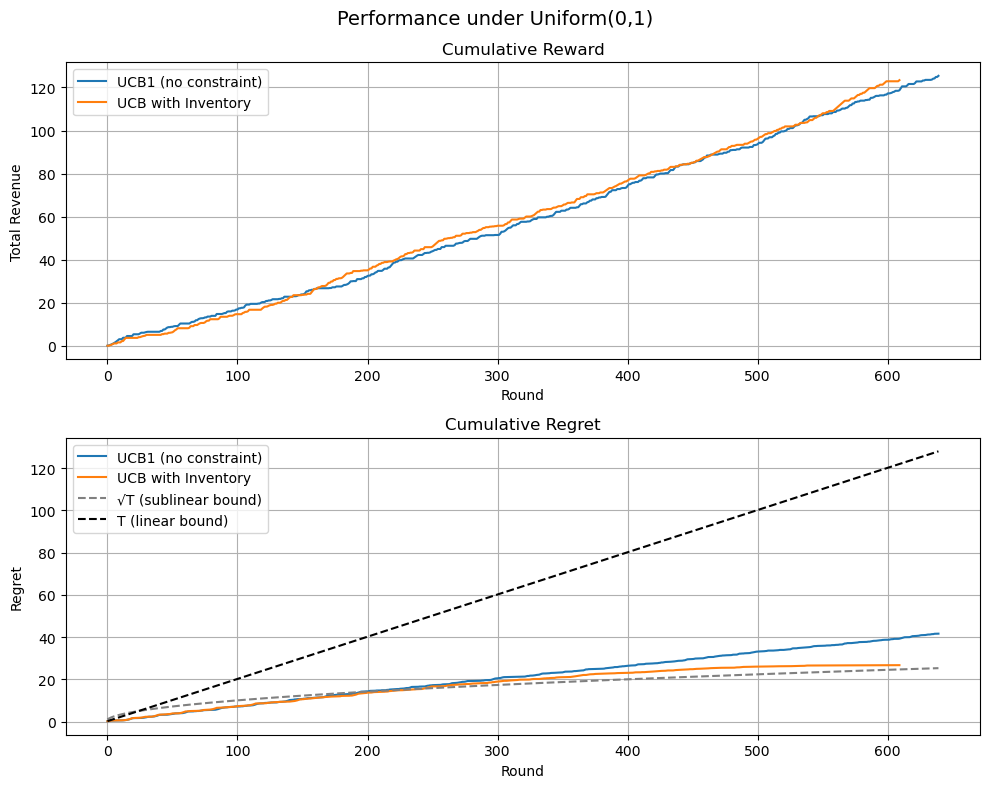

In [13]:
# --- Plotting ---
for dist_name in distributions:
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(f"Performance under {dist_name}", fontsize=14)

    # Plot cumulative rewards
    for agent_name in agents:
        axs[0].plot(results[dist_name][agent_name]["reward"], label=agent_name)

    # Prepare regret bounds
    T = len(next(iter(results[dist_name].values()))["regret"])
    rounds = np.arange(1, T + 1)
    sqrt_T = np.sqrt(rounds)
    linear_T = rounds / 5  # scaled for visibility

    # Plot cumulative regrets
    for agent_name in agents:
        axs[1].plot(results[dist_name][agent_name]["regret"], label=agent_name)

    # Plot reference curves
    axs[1].plot(sqrt_T, '--', label="√T (sublinear bound)", color="gray")
    axs[1].plot(linear_T, '--', label="T (linear bound)", color="black")

    # Format reward plot
    axs[0].set_title("Cumulative Reward")
    axs[0].set_xlabel("Round")
    axs[0].set_ylabel("Total Revenue")
    axs[0].legend()
    axs[0].grid(True)

    # Format regret plot
    axs[1].set_title("Cumulative Regret")
    axs[1].set_xlabel("Round")
    axs[1].set_ylabel("Regret")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


# Requirement 2 - Multiple products and stochastic environment

In [14]:
class MultiProductEnvironment:
    def __init__(self, price_sets, valuation_distribution, horizon, budget):
        """
        price_sets: list of arrays, one for each product's possible prices
        valuation_distribution: function that returns a vector of valuations (1 per product)
        """
        self.price_sets = price_sets
        self.N = len(price_sets)  # Number of products
        self.valuation_distribution = valuation_distribution
        self.T = horizon
        self.B = budget
        self.inventory_used = 0

    def buyer_valuation(self):
        return self.valuation_distribution()

    def step(self, price_vector):
        """
        price_vector: selected prices for each product, one per product
        Returns:
            rewards: list of rewards per product
            purchased_flags: list of booleans per product
        """
        if self.inventory_used >= self.B:
            return [0]*self.N, [False]*self.N  # budget exhausted

        valuations = self.buyer_valuation()
        rewards = []
        purchased_flags = []
        for i in range(self.N):
            if valuations[i] >= price_vector[i]:
                rewards.append(price_vector[i])
                purchased_flags.append(True)
            else:
                rewards.append(0)
                purchased_flags.append(False)

        self.inventory_used += sum(purchased_flags)
        return rewards, purchased_flags

    def reset(self):
        self.inventory_used = 0


In [15]:
class CombinatorialUCB(Agent):
    def __init__(self, price_sets):
        """
        price_sets: list of arrays, one for each product's possible prices
        """
        self.price_sets = price_sets
        self.N = len(price_sets)
        self.K = [len(ps) for ps in price_sets]  # number of arms per product

        # Initialize counts and rewards
        self.counts = [np.zeros(k) for k in self.K]     # per product
        self.rewards = [np.zeros(k) for k in self.K]
        self.total_steps = 0

    def select_price(self, t):
        """
        Selects a price for each product using UCB.
        """
        price_vector = []
        for i in range(self.N):
            if t <= self.K[i]:
                # play each arm once for product i
                price_vector.append(self.price_sets[i][t % self.K[i]])
            else:
                avg_rewards = self.rewards[i] / np.maximum(1, self.counts[i])
                confidence = np.sqrt((2 * np.log(t)) / np.maximum(1, self.counts[i]))
                ucb = avg_rewards + confidence
                best_arm = np.argmax(ucb)
                price_vector.append(self.price_sets[i][best_arm])
        return price_vector

    def update(self, price_vector, rewards):
        """
        Update statistics after observing reward vector.
        """
        for i in range(self.N):
            price = price_vector[i]
            reward = rewards[i]
            price_list = self.price_sets[i].tolist()
            index = price_list.index(price)
            self.counts[i][index] += 1
            self.rewards[i][index] += reward
        self.total_steps += 1


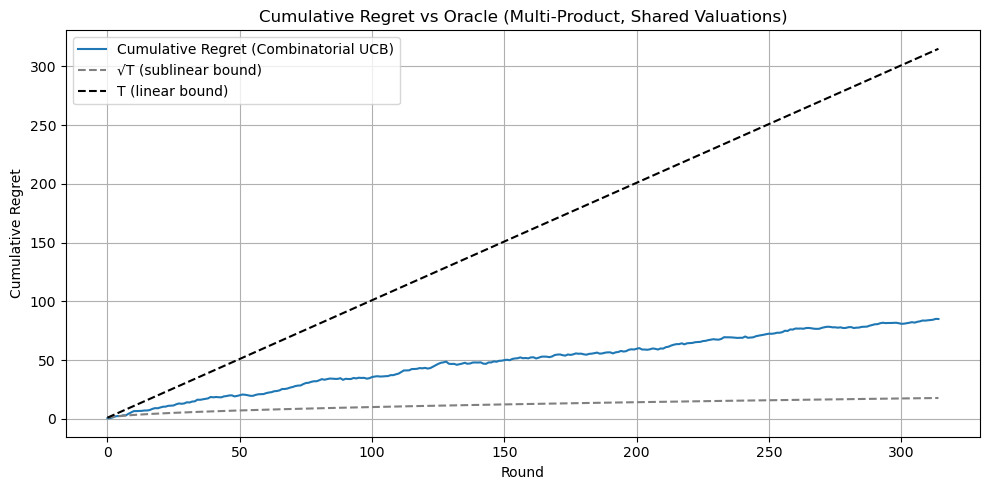

Final cumulative regret: 85.0
Total UCB reward: 235.3


In [16]:
# Define simulation for multi-product setting
def simulate_multi(env, agent):
    rewards_total = []
    price_choices = []
    
    for t in range(1, env.T + 1):
        if env.inventory_used >= env.B:
            break
        price_vector = agent.select_price(t)
        rewards, _ = env.step(price_vector)
        agent.update(price_vector, rewards)
        rewards_total.append(sum(rewards))
        price_choices.append(price_vector)
    return rewards_total, price_choices

# Setup for 3 products
price_sets = [np.round(np.linspace(0.1, 1.0, 10), 2) for _ in range(3)]  # 5 price points per product

# Joint valuation distribution (independent distribution per product)
def heterogeneous_valuations():
    return np.array([
        np.random.beta(2, 5),   # Product 1 → low valuations
        np.random.beta(7, 1),   # Product 2 → high valuations
        np.random.uniform(0, 1) # Product 3 → uniform
    ])

valuation_distribution = heterogeneous_valuations

horizon = 1000
budget = 500

# --- Compute Regret Using Simultaneous Oracle ---
rewards_total = []
price_choices = []
oracle_rewards = []
instant_regrets = []

env = MultiProductEnvironment(price_sets, valuation_distribution, horizon, budget)
agent = CombinatorialUCB(price_sets)

# Pre-compute oracle best price per product based on expected value
oracle_prices = []

n_samples = 1000
valuations = np.array([valuation_distribution() for _ in range(n_samples)])

for i in range(len(price_sets)):
    expected_rewards = [p * np.mean(valuations[:, i] >= p) for p in price_sets[i]]
    best_price = price_sets[i][np.argmax(expected_rewards)]
    oracle_prices.append(best_price)

    
for t in range(1, env.T + 1):
    if env.inventory_used >= env.B:
        break

    price_vector = agent.select_price(t)
    
    # Get buyer valuation
    valuation = valuation_distribution()

    # Agent reward
    reward_vector, _ = env.step(price_vector)
    agent.update(price_vector, reward_vector)
    agent_reward = sum(reward_vector)

    # Oracle reward using same valuation
    oracle_reward = 0
    for i in range(len(price_sets)):
        if valuation[i] >= oracle_prices[i]:
            oracle_reward += oracle_prices[i]

    rewards_total.append(agent_reward)
    price_choices.append(price_vector)
    oracle_rewards.append(oracle_reward)
    instant_regrets.append(oracle_reward - agent_reward)

# --- Calculate Cumulative Metrics ---
cumulative_rewards = np.cumsum(rewards_total)
cumulative_oracle = np.cumsum(oracle_rewards)
cumulative_regret = np.cumsum(instant_regrets)


# Regret bounds
T = len(cumulative_regret)
rounds = np.arange(1, T + 1)
sqrt_T = np.sqrt(rounds)
linear_T = rounds

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_regret, label="Cumulative Regret (Combinatorial UCB)")
plt.plot(sqrt_T, '--', label="√T (sublinear bound)", color="gray")
plt.plot(linear_T, '--', label="T (linear bound)", color="black")
plt.title("Cumulative Regret vs Oracle (Multi-Product, Shared Valuations)")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


print("Final cumulative regret:", cumulative_regret[-1])
#print("Total oracle reward:", oracle_total)
print("Total UCB reward:", cumulative_rewards[-1])

def compute_total_oracle_reward(price_sets, valuation_distribution, n_samples=100000):
    valuations = np.array([valuation_distribution() for _ in range(n_samples)])  # shape: [n_samples, N]
    best_rewards = []
    for i in range(len(price_sets)):
        expected_rewards = [p * np.mean(valuations[:, i] >= p) for p in price_sets[i]]
        best_rewards.append(np.max(expected_rewards))
    return np.sum(best_rewards)

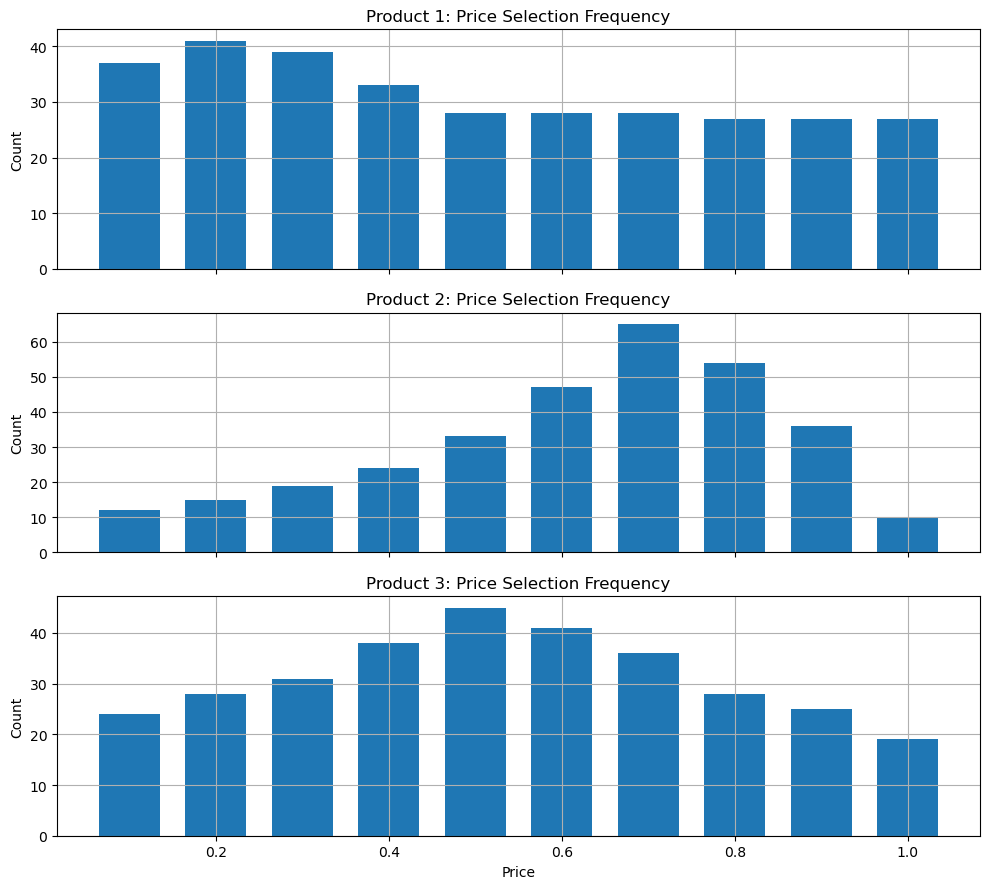

In [17]:
# Prepare data for plotting per-product statistics
N = len(price_sets)  # number of products
price_counts = [np.zeros(len(price_sets[i])) for i in range(N)]

# Count how often each price was chosen for each product
for vector in price_choices:
    for i in range(N):
        price = vector[i]
        idx = price_sets[i].tolist().index(price)
        price_counts[i][idx] += 1

# Plot histograms of price selections per product
fig, axs = plt.subplots(N, 1, figsize=(10, 3 * N), sharex=True)

for i in range(N):
    axs[i].bar(price_sets[i], price_counts[i], width=0.07)
    axs[i].set_title(f"Product {i+1}: Price Selection Frequency")
    axs[i].set_ylabel("Count")
    axs[i].grid(True)

axs[-1].set_xlabel("Price")
plt.tight_layout()
plt.show()


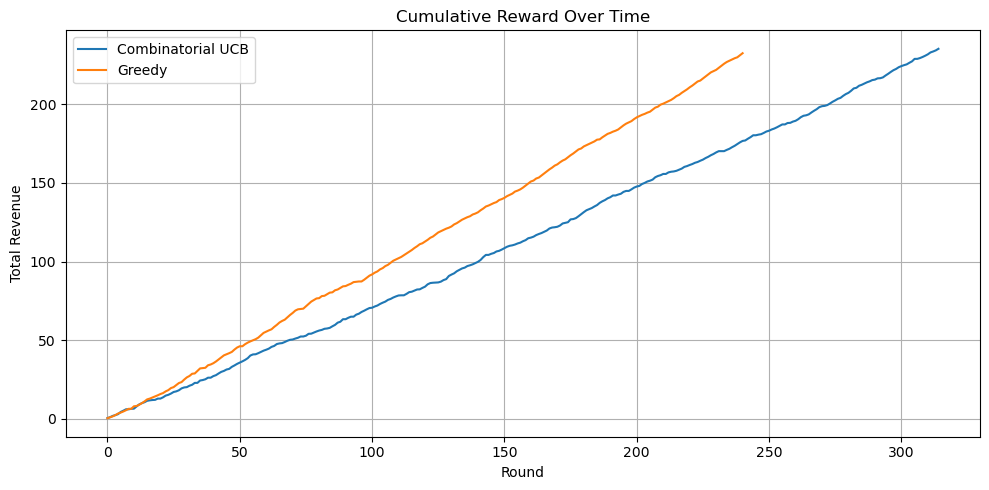

In [18]:
class GreedyAgent(Agent):
    def __init__(self, price_sets):
        self.price_sets = price_sets
        self.N = len(price_sets)
        self.K = [len(ps) for ps in price_sets]
        self.counts = [np.zeros(k) for k in self.K]
        self.rewards = [np.zeros(k) for k in self.K]
        self.total_steps = 0

    def select_price(self, t):
        price_vector = []
        for i in range(self.N):
            if self.counts[i].sum() < self.K[i]:
                # Pull each arm once
                next_index = int(self.counts[i].sum())
                price_vector.append(self.price_sets[i][next_index])
            else:
                avg_rewards = self.rewards[i] / np.maximum(1, self.counts[i])
                best_arm = np.argmax(avg_rewards)
                price_vector.append(self.price_sets[i][best_arm])
        return price_vector

    def update(self, price_vector, rewards):
        for i in range(self.N):
            price = price_vector[i]
            reward = rewards[i]
            price_list = self.price_sets[i].tolist()
            index = price_list.index(price)
            self.counts[i][index] += 1
            self.rewards[i][index] += reward
        self.total_steps += 1


# Simulate greedy agent
env_greedy = MultiProductEnvironment(price_sets, valuation_distribution, horizon, budget)
agent_greedy = GreedyAgent(price_sets)
rewards_greedy, _ = simulate_multi(env_greedy, agent_greedy)


cumulative_ucb = np.cumsum(rewards_total)
cumulative_greedy = np.cumsum(rewards_greedy)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_ucb, label="Combinatorial UCB")
plt.plot(cumulative_greedy, label="Greedy")
plt.title("Cumulative Reward Over Time")
plt.xlabel("Round")
plt.ylabel("Total Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Requirement 3 - Best-of-both-worlds algorithms with a single product

In [19]:
# --- Non-Stationary Valuation Distribution ---
def non_stationary_valuation(t, T):
    # Switch every T//4 rounds between two different beta distributions
    if t < T % 4:
        return np.random.beta(2, 5)
    elif t < T % 2:
        return np.random.beta(5, 2)
    elif t < 3 * T % 4:
        return np.random.beta(3, 3)
    else:
        return np.random.beta(6, 1)

class NonStationaryEnvironment(SingleProductEnvironment):
    def __init__(self, prices, horizon, budget):
        super().__init__(prices, None, horizon, budget)

    def buyer_valuation(self, t):
        return non_stationary_valuation(t, self.T)

    def step(self, price, t):
        if self.inventory_used >= self.B:
            return 0, False

        valuation = self.buyer_valuation(t)
        if valuation >= price:
            self.inventory_used += 1
            return price, True
        else:
            return 0, False

In [20]:
class PrimalDualAgent(Agent):
    def __init__(self, prices, budget, horizon, eta=0.05):
        super().__init__(prices)
        self.lambda_t = 0.0
        self.eta = eta
        self.B = budget
        self.T = horizon
        self.history = []

    def select_price(self, t, valuation):
        # Only consider prices the buyer is willing to pay
        valid_prices = [p for p in self.prices if valuation >= p]
        if not valid_prices:
            return None  # no sale possible

        # Select price that maximizes p - λ
        best_price = max(valid_prices, key=lambda p: p - self.lambda_t)
        return best_price

    def update(self, sold):
        x_t = 1 if sold else 0
        self.lambda_t = max(0.0, self.lambda_t + self.eta * (x_t - self.B / self.T))

In [21]:
# Parameters
prices = np.round(np.linspace(0.1, 1.0, 10), 2)
horizon = 1000
budget = 500

env = NonStationaryEnvironment(prices, horizon, budget)
agent = PrimalDualAgent(prices, budget, horizon, eta=0.05)

rewards = []
lambda_trace = []

for t in range(1, horizon + 1):
    if env.inventory_used >= env.B:
        break

    valuation = env.buyer_valuation(t)
    price = agent.select_price(t, valuation)

    if price is None:
        rewards.append(0)
        lambda_trace.append(agent.lambda_t)
        continue

    reward, sold = env.step(price, t)
    agent.update(sold)

    rewards.append(reward)
    lambda_trace.append(agent.lambda_t)


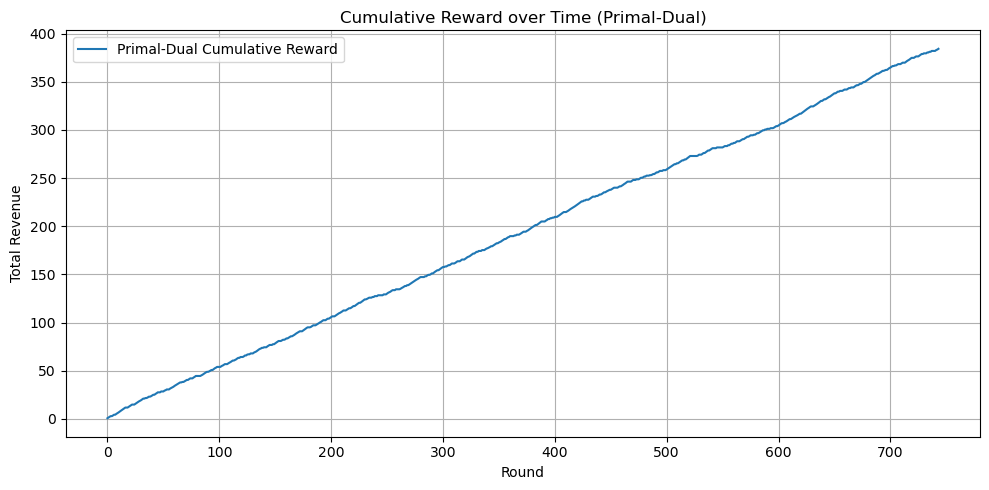

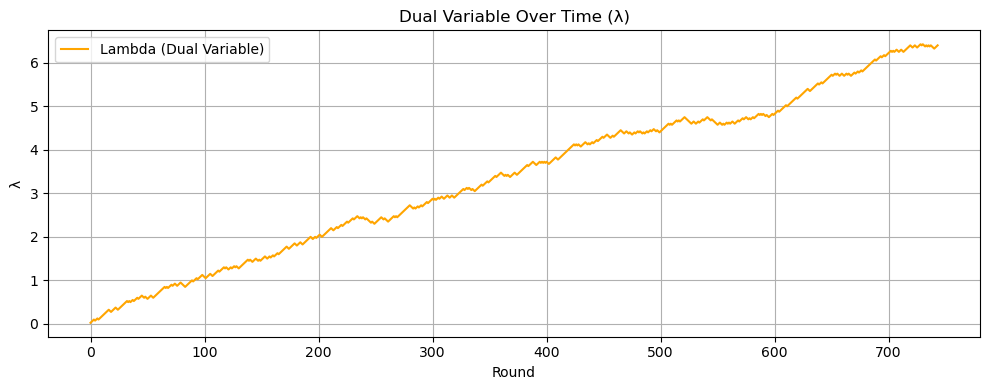

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(rewards), label="Primal-Dual Cumulative Reward")
plt.title("Cumulative Reward over Time (Primal-Dual)")
plt.xlabel("Round")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(lambda_trace, label="Lambda (Dual Variable)", color="orange")
plt.title("Dual Variable Over Time (λ)")
plt.xlabel("Round")
plt.ylabel("λ")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


# Requirements 4 and 5: Best-of-both-worlds algorithms with a multiple products (slightly and highly non-stationary environments)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [25]:
class NonStationaryEnvironment:
    """
    Highly non-stationary environment for multiple products.
    Valuations change every 'change_interval' steps.
    Note: Doesn't have to be a fixed number of steps
    """

    def __init__(self, T, N, price_set, change_interval=50):
        self.T = T
        self.N = N
        self.price_set = price_set
        self.change_interval = change_interval
        self.round = 0
        self._generate_new_distributions()

    def _generate_new_distributions(self):
        self.means = np.random.uniform(0.2, 0.9, self.N)
        self.std = np.random.uniform(0.05, 0.15, self.N)

    def step(self):
        if self.round % self.change_interval == 0:
            self._generate_new_distributions()
        self.round += 1
        valuations = np.clip(np.random.normal(self.means, self.std), 0, 1)
        return valuations


In [26]:
class PiecewiseStationaryEnvironment:
    """
    Slightly non-stationary environment. Changes occur at fixed known intervals.
    """

    def __init__(self, T, N, price_set, segments=5):
        self.T = T
        self.N = N
        self.price_set = price_set
        self.segments = segments
        self.change_points = np.linspace(0, T, segments+1, dtype=int)
        self.round = 0
        self._generate_distributions()

    def _generate_distributions(self):
        self.segment_distributions = []
        for _ in range(self.segments):
            mean = np.random.uniform(0.3, 0.8, self.N)
            std = np.random.uniform(0.05, 0.1, self.N)
            self.segment_distributions.append((mean, std))

    def step(self):
        segment = np.searchsorted(self.change_points, self.round, side='right') - 1
        mean, std = self.segment_distributions[segment]
        self.round += 1
        return np.clip(np.random.normal(mean, std), 0, 1)


In [27]:
class AdversarialRegretMinimizer:
    """
    Hedge-style regret minimizer for each product.
    """
    
    def __init__(self, price_set, eta=None):
        self.prices = np.array(price_set)
        self.K = len(price_set)
        # Set eta adaptively
        self.eta = eta if eta is not None else np.sqrt(np.log(self.K) / 1000)  
        self.weights = np.ones(self.K)
        self.t = 0
    
    def select_price(self):
        probs = self.weights / np.sum(self.weights)
        choice = np.random.choice(self.K, p=probs)
        return self.prices[choice], choice
    
    def update(self, choice_idx, reward):
        # Exponential weighting with safer computation
        prob = self.weights[choice_idx] / np.sum(self.weights)
        est_reward = reward / max(prob, 1e-10)  # Avoid division by zero
        self.weights[choice_idx] *= np.exp(self.eta * est_reward)
        
        # Prevent overflow
        if np.max(self.weights) > 1e10:
            self.weights /= np.max(self.weights)


In [28]:
class PrimalDualMultiProduct:
    """
    Primal-dual algorithm: decomposes the problem into N per-product regret minimizers.
    """
    
    def __init__(self, N, B, price_set):
        self.N = N
        self.B = B
        self.remaining = B
        self.minimizers = [AdversarialRegretMinimizer(price_set) for _ in range(N)]
        self.price_set = np.array(price_set)
        self.t = 0
    
    def play_round(self, valuations):
        self.t += 1
        
        # Get price choices from each minimizer
        chosen_prices = []
        choices = []
        for i in range(self.N):
            p, idx = self.minimizers[i].select_price()
            chosen_prices.append(p)
            choices.append(idx)
        
        # Determine purchases with inventory constraint
        purchases = []
        for p, v in zip(chosen_prices, valuations):
            if p < v and self.remaining > 0:
                purchases.append(1)
                self.remaining -= 1
            else:
                purchases.append(0)
        
        # Update each minimizer
        total_revenue = 0
        for i in range(self.N):
            reward = chosen_prices[i] if purchases[i] else 0
            self.minimizers[i].update(choices[i], reward)
            total_revenue += reward
        
        return total_revenue


In [29]:
class SlidingWindowCUCB:
    """Sliding window UCB algorithm
       Calculates bounds based on last window_size steps 
    """
    
    def __init__(self, N, B, price_set, window_size=50, alpha=2.0):
        self.N = N
        self.B = B
        self.remaining = B
        self.price_set = np.array(price_set)
        self.K = len(price_set)
        self.window_size = window_size
        self.alpha = alpha  # Confidence parameter
        
        # Store recent rewards for each product-price pair
        self.rewards = [[deque(maxlen=window_size) for _ in range(self.K)] for _ in range(N)]
        self.t = 0
    
    def select_prices(self):
        self.t += 1
        prices = []
        indices = []
        
        for i in range(self.N):
            ucbs = []
            total_pulls = sum(len(self.rewards[i][k]) for k in range(self.K))
            
            for k in range(self.K):
                if len(self.rewards[i][k]) == 0:
                    ucbs.append(float('inf'))  # Force exploration
                else:
                    mean_reward = np.mean(self.rewards[i][k])
                    n_k = len(self.rewards[i][k])
                    
                    # UCB with sliding window
                    if total_pulls > 0:
                        confidence = np.sqrt(self.alpha * np.log(total_pulls) / n_k)
                    else:
                        confidence = float('inf')
                    
                    ucbs.append(mean_reward + confidence)
            
            idx = np.argmax(ucbs)
            prices.append(self.price_set[idx])
            indices.append(idx)
        
        return prices, indices
    
    def play_round(self, valuations):
        prices, indices = self.select_prices()
        
        # Determine purchases with inventory constraint
        purchases = []
        remaining_this_round = self.remaining
        
        for i in range(self.N):
            if prices[i] < valuations[i] and remaining_this_round > 0:
                purchases.append(1)
                remaining_this_round -= 1
            else:
                purchases.append(0)
        
        # Update global inventory
        self.remaining = remaining_this_round
        
        # Update reward history
        total_revenue = 0
        for i in range(self.N):
            reward = prices[i] if purchases[i] else 0
            self.rewards[i][indices[i]].append(reward)
            total_revenue += reward
        
        return total_revenue


In [30]:
def evaluate(env_class, algo_class, T=500, N=5, B=300, price_set=[0.1, 0.2, 0.4, 0.6, 0.8]):
    """
    Runs a sumulation, calculates rewards and valuations
    """
    env = env_class(T, N, price_set)
    algo = algo_class(N, B, price_set)
    rewards = []
    valuations_history = [] 
    for t in range(T):
        valuations = env.step()
        valuations_history.append(valuations.copy()) 
        reward = algo.play_round(valuations)
        rewards.append(reward)
    return np.cumsum(rewards), valuations_history 


In [31]:
def compute_dynamic_oracle_rewards(valuations_history, N, B, price_set, segments=5):
    """
    Computes oracle rewards using the same valuation sequence as algorithms
    """
    T = len(valuations_history)
    segment_length = T // segments
    
    total_reward = 0
    remaining = B
    oracle_rewards = []
    
    # Pre-compute best prices per segment using actual valuations
    best_prices_per_segment = []
    for seg in range(segments):
        start_idx = seg * segment_length
        end_idx = (seg + 1) * segment_length if seg < segments - 1 else T
        
        # Use actual valuations from this segment
        segment_valuations = np.array(valuations_history[start_idx:end_idx])
        
        best_prices = []
        for i in range(N):
            best_revenue = 0
            best_price = price_set[0]
            
            for p in price_set:
                purchases = (segment_valuations[:, i] > p).astype(int)
                avg_revenue = np.mean(purchases) * p
                
                if avg_revenue > best_revenue:
                    best_revenue = avg_revenue
                    best_price = p
            
            best_prices.append(best_price)
        best_prices_per_segment.append(best_prices)
    
    # Simulate oracle with inventory handling
    for t in range(T):
        seg = min(t // segment_length, segments - 1)
        valuations = valuations_history[t]
        best_prices = best_prices_per_segment[seg]
        
        # Apply inventory constraint
        purchases = []
        for p, v in zip(best_prices, valuations):
            if p < v and remaining > 0:
                purchases.append(1)
                remaining -= 1
            else:
                purchases.append(0)
        
        reward = sum(p * b for p, b in zip(best_prices, purchases))
        total_reward += reward
        oracle_rewards.append(total_reward)
    
    return np.array(oracle_rewards)


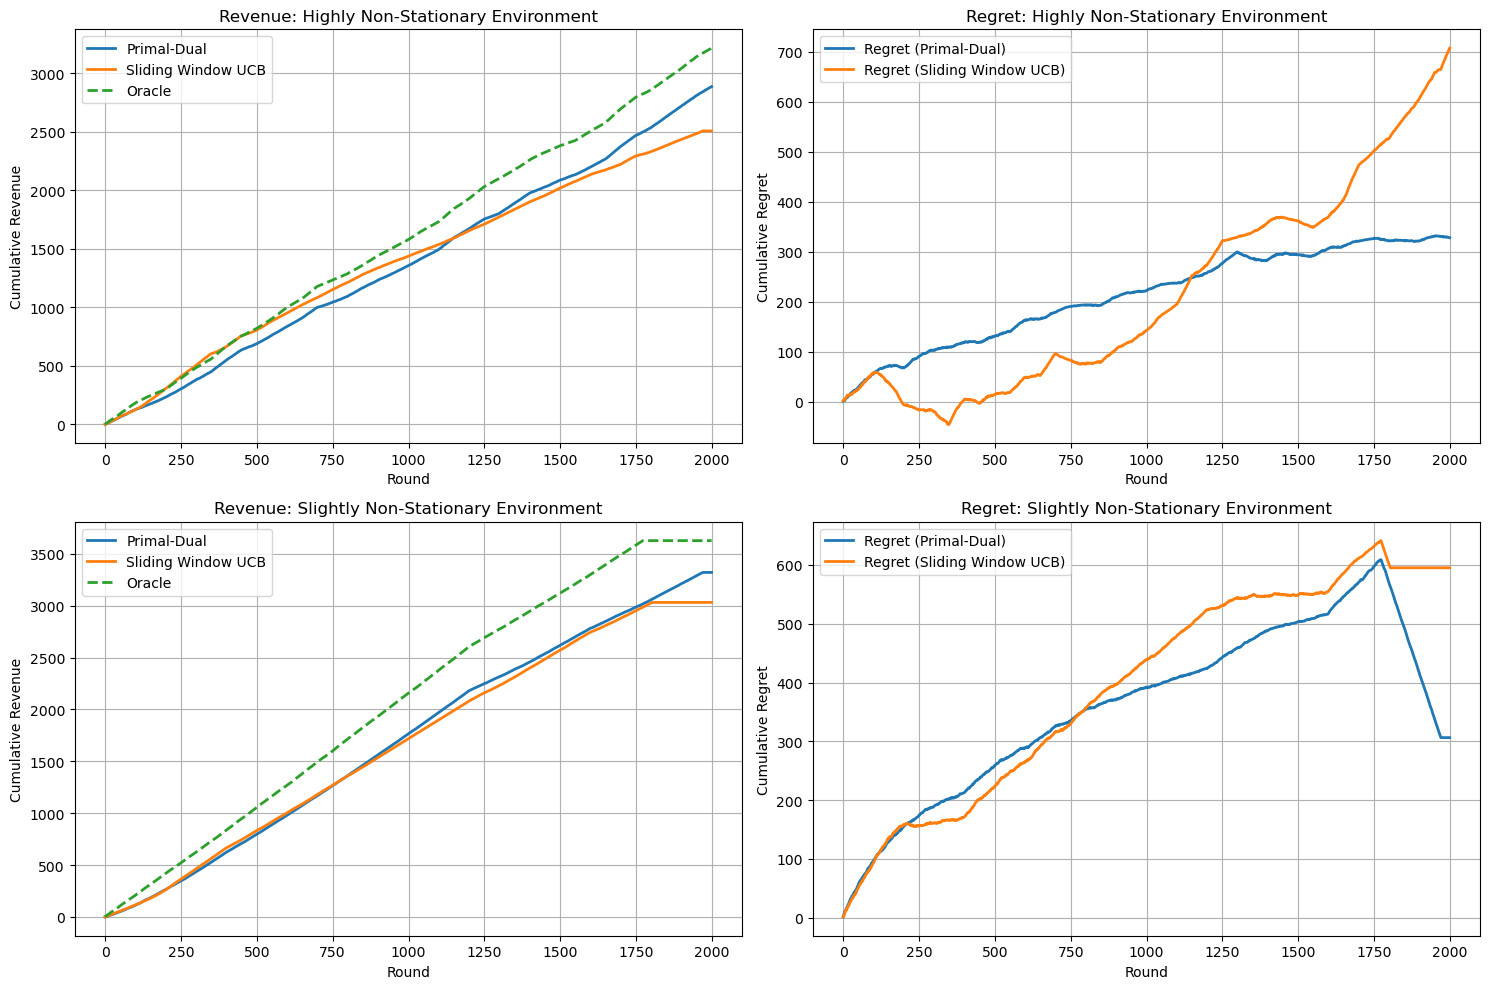

In [32]:
# This part of code tests both algorithms in both environments

T = 2000
N = 5
B = 8000

price_set = np.linspace(0.1, 0.9, 7) 


# Testing both algorithms on HIGHLY non-stationary environment
np.random.seed(0)
pd_rewards_nonstat, valuations_history_nonstat = evaluate(NonStationaryEnvironment, PrimalDualMultiProduct, T, N, B, price_set)
np.random.seed(0)
sw_rewards_nonstat, _ = evaluate(NonStationaryEnvironment, SlidingWindowCUCB, T, N, B, price_set)

oracle_rewards_nonstat = compute_dynamic_oracle_rewards(valuations_history_nonstat, N, B, price_set, segments=5)
regret_pd_nonstat = oracle_rewards_nonstat - pd_rewards_nonstat
regret_sw_nonstat = oracle_rewards_nonstat - sw_rewards_nonstat

# Test 2: Both algorithms on SLIGHTLY non-stationary environment  
np.random.seed(0)
pd_rewards_piecewise, valuations_history_piecewise = evaluate(PiecewiseStationaryEnvironment, PrimalDualMultiProduct, T, N, B, price_set)
np.random.seed(0)
sw_rewards_piecewise, _ = evaluate(PiecewiseStationaryEnvironment, SlidingWindowCUCB, T, N, B, price_set)

oracle_rewards_piecewise = compute_dynamic_oracle_rewards(valuations_history_piecewise, N, B, price_set, segments=5)
regret_pd_piecewise = oracle_rewards_piecewise - pd_rewards_piecewise
regret_sw_piecewise = oracle_rewards_piecewise - sw_rewards_piecewise

# Comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Revenue in highly non-stationary environment
ax1.plot(pd_rewards_nonstat, label="Primal-Dual", linewidth=2)
ax1.plot(sw_rewards_nonstat, label="Sliding Window UCB", linewidth=2)
ax1.plot(oracle_rewards_nonstat, label="Oracle", linestyle='--', linewidth=2)
ax1.set_xlabel("Round")
ax1.set_ylabel("Cumulative Revenue")
ax1.set_title("Revenue: Highly Non-Stationary Environment")
ax1.legend()
ax1.grid(True)

# Regret in highly non-stationary environment
ax2.plot(regret_pd_nonstat, label="Regret (Primal-Dual)", linewidth=2)
ax2.plot(regret_sw_nonstat, label="Regret (Sliding Window UCB)", linewidth=2)
ax2.set_xlabel("Round")
ax2.set_ylabel("Cumulative Regret")
ax2.set_title("Regret: Highly Non-Stationary Environment")
ax2.legend()
ax2.grid(True)

# Revenue in slightly non-stationary environment
ax3.plot(pd_rewards_piecewise, label="Primal-Dual", linewidth=2)
ax3.plot(sw_rewards_piecewise, label="Sliding Window UCB", linewidth=2)
ax3.plot(oracle_rewards_piecewise, label="Oracle", linestyle='--', linewidth=2)
ax3.set_xlabel("Round")
ax3.set_ylabel("Cumulative Revenue")
ax3.set_title("Revenue: Slightly Non-Stationary Environment")
ax3.legend()
ax3.grid(True)

# Regret in slightly non-stationary environment
ax4.plot(regret_pd_piecewise, label="Regret (Primal-Dual)", linewidth=2)
ax4.plot(regret_sw_piecewise, label="Regret (Sliding Window UCB)", linewidth=2)
ax4.set_xlabel("Round")
ax4.set_ylabel("Cumulative Regret")
ax4.set_title("Regret: Slightly Non-Stationary Environment")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


In [33]:
# Print final results

print(f"\nHighly Non-Stationary Environment:")
print(f"Final Regret - Primal-Dual: {regret_pd_nonstat[-1]:.2f}")
print(f"Final Regret - Sliding Window UCB: {regret_sw_nonstat[-1]:.2f}")

print(f"\nSlightly Non-Stationary Environment:")
print(f"Final Regret - Primal-Dual: {regret_pd_piecewise[-1]:.2f}")
print(f"Final Regret - Sliding Window UCB: {regret_sw_piecewise[-1]:.2f}")


Highly Non-Stationary Environment:
Final Regret - Primal-Dual: 327.97
Final Regret - Sliding Window UCB: 706.90

Slightly Non-Stationary Environment:
Final Regret - Primal-Dual: 306.27
Final Regret - Sliding Window UCB: 595.20
